# Task 4 — Proxy Target Variable Engineering
Objective: Create a high-risk target variable based on customer transaction history using RFM metrics and clustering.


## Step 1 — Define Snapshot Date
We define a snapshot date as one day after the latest transaction in the dataset to calculate Recency.


In [2]:
# Cell 1 — Load processed data
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load your processed data
df = pd.read_csv("../data/processed/processed_data.csv")  # adjust path if needed

# Ensure TransactionStartTime is in datetime format
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

print("Data loaded and datetime conversion done")
df.head()


Data loaded and datetime conversion done


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,TransactionAmountStd,UniqueProductCategories,UniqueChannels,FraudRate,TransactionHour,TransactionDay,TransactionMonth,TransactionYear,DayOfWeek,IsWeekend
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,3042.294251,3,3,0.0,2,15,11,2018,3,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,3042.294251,3,3,0.0,2,15,11,2018,3,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,0.000000,1,1,0.0,2,15,11,2018,3,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,17169.241610,5,3,0.0,3,15,11,2018,3,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,17169.241610,5,3,0.0,3,15,11,2018,3,0


In [3]:
snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)
print("Snapshot date for recency calculation:", snapshot_date)


Snapshot date for recency calculation: 2019-02-14 10:01:28+00:00


## Step 2 — Calculate RFM Metrics
- **Recency:** Days since last transaction.
- **Frequency:** Total number of transactions.
- **Monetary:** Total transaction amount.


In [4]:
# Aggregate RFM metrics per customer
rfm = df.groupby('CustomerId').agg(
    Recency = ('TransactionStartTime', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('TransactionId', 'count'),
    Monetary = ('Amount', 'sum')
).reset_index()

rfm.head()


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0


## Step 3 — Scale RFM Features
Scaling ensures meaningful clustering.


In [5]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


## Step 4 — Cluster Customers with K-Means
We create 3 clusters representing different engagement levels.


In [6]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()


,CustomerId,Recency,Frequency,Monetary,Cluster
0,CustomerId_1,84,1,-10000.0,0
1,CustomerId_10,84,1,-10000.0,0
2,CustomerId_1001,90,5,20000.0,0
3,CustomerId_1002,26,11,4225.0,2
4,CustomerId_1003,12,6,20000.0,2


## Step 5 — Identify High-Risk Cluster
High-risk customers are typically low frequency and low monetary. We check the mean RFM per cluster.


In [7]:
cluster_summary = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().sort_values(by=['Frequency','Monetary'])
print(cluster_summary)

# Assume the first row after sorting is high-risk
high_risk_cluster = cluster_summary.index[0]
print("High-risk cluster ID:", high_risk_cluster)


           Recency    Frequency      Monetary
Cluster                                      
0        61.859846     7.726699  8.172379e+04
2        12.716076    34.807692  2.726546e+05
1        29.000000  4091.000000 -1.049000e+08
High-risk cluster ID: 0


## Step 6 — Assign Binary Target
Create a new column `is_high_risk`: 1 for high-risk cluster, 0 for others.


In [8]:
rfm['is_high_risk'] = (rfm['Cluster'] == high_risk_cluster).astype(int)
rfm[['CustomerId','is_high_risk']].head()


,CustomerId,is_high_risk
0,CustomerId_1,1
1,CustomerId_10,1
2,CustomerId_1001,1
3,CustomerId_1002,0
4,CustomerId_1003,0


## Step 7 — Merge Target Back to Main Dataset
Integrate the new proxy target variable into the main processed dataset.


In [9]:
df = df.merge(rfm[['CustomerId','is_high_risk']], on='CustomerId', how='left')
df[['CustomerId','is_high_risk']].drop_duplicates().head()


,CustomerId,is_high_risk
0,CustomerId_4406,0
2,CustomerId_4683,1
3,CustomerId_988,0
5,CustomerId_1432,1
6,CustomerId_2858,0


## Step 8 — Save Updated Dataset
Save the dataset with the new target variable to `data/processed`.


In [10]:
df.to_csv("../data/processed/processed_data_with_target.csv", index=False)
print("Processed data with 'is_high_risk' saved to data/processed/processed_data_with_target.csv")


Processed data with 'is_high_risk' saved to data/processed/processed_data_with_target.csv


# Task 4 —  Visualizations
Objective: Identify high-risk customers and visualize RFM clusters.


In [11]:
# Cell 1 — Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns


## Step 1 — Distribution of RFM Metrics
Visualize Recency, Frequency, and Monetary distributions to understand overall customer behavior.


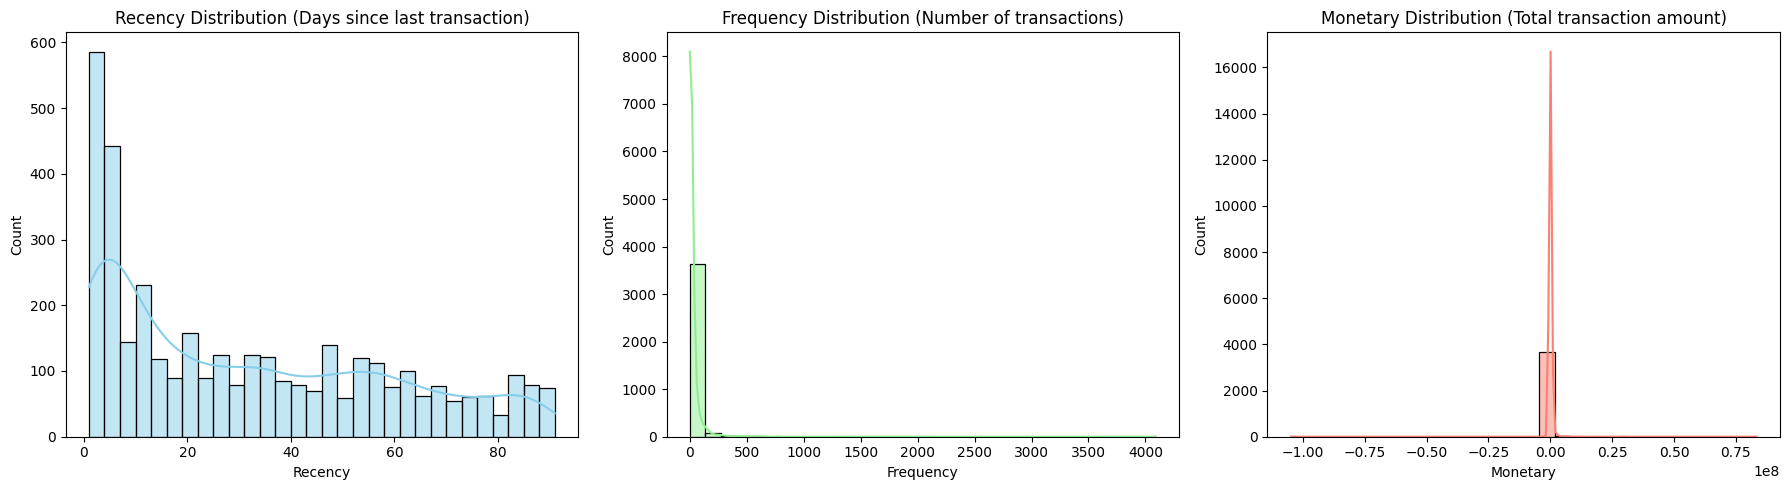

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(rfm['Recency'], bins=30, ax=axes[0], kde=True, color='skyblue')
axes[0].set_title('Recency Distribution (Days since last transaction)')

sns.histplot(rfm['Frequency'], bins=30, ax=axes[1], kde=True, color='lightgreen')
axes[1].set_title('Frequency Distribution (Number of transactions)')

sns.histplot(rfm['Monetary'], bins=30, ax=axes[2], kde=True, color='salmon')
axes[2].set_title('Monetary Distribution (Total transaction amount)')

plt.tight_layout()
plt.show()


## Step 2 — Visualize K-Means Clusters
We can plot Recency vs Frequency colored by cluster and highlight high-risk cluster.


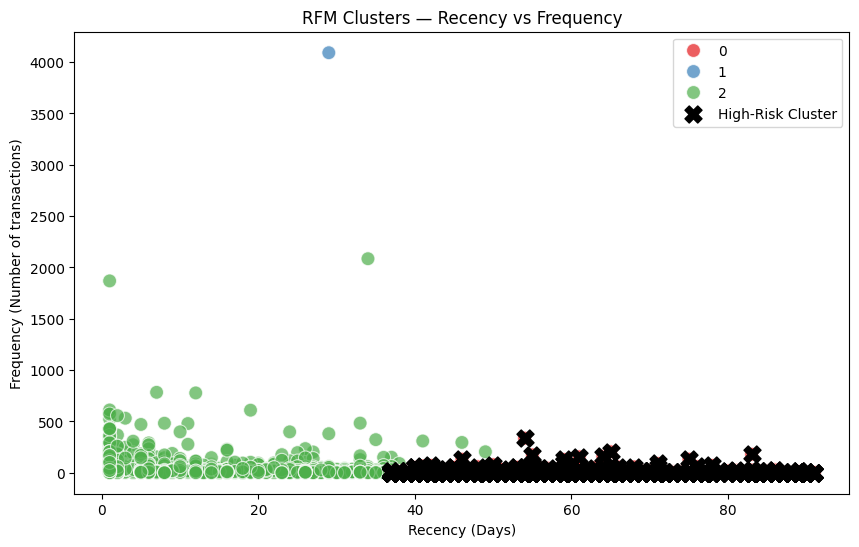

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='Recency', y='Frequency', 
    hue='Cluster', 
    palette='Set1', data=rfm, s=100, alpha=0.7
)
plt.scatter(
    rfm[rfm['Cluster']==high_risk_cluster]['Recency'], 
    rfm[rfm['Cluster']==high_risk_cluster]['Frequency'],
    s=150, color='black', label='High-Risk Cluster', marker='X'
)
plt.title('RFM Clusters — Recency vs Frequency')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (Number of transactions)')
plt.legend()
plt.show()


## Step 3 — Pairplot of RFM Colored by High-Risk
Visualize all three RFM features together to see separation.


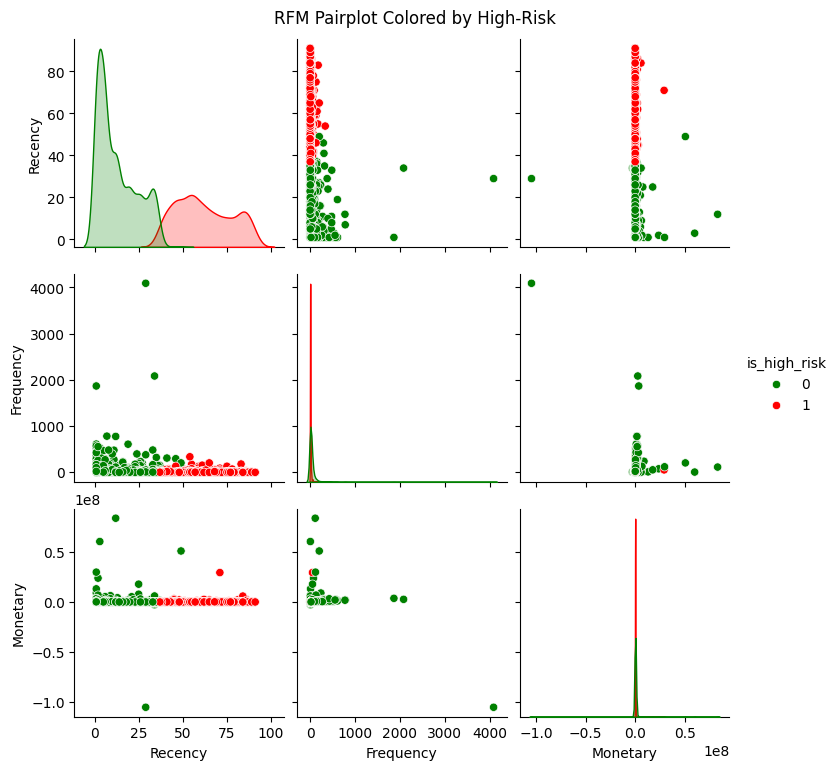

In [14]:
sns.pairplot(rfm, vars=['Recency','Frequency','Monetary'], hue='is_high_risk', palette={0:'green',1:'red'})
plt.suptitle('RFM Pairplot Colored by High-Risk', y=1.02)
plt.show()


## Step 4 — Cluster Summary Bar Plots
Compare mean Recency, Frequency, and Monetary per cluster to see which cluster is high-risk.


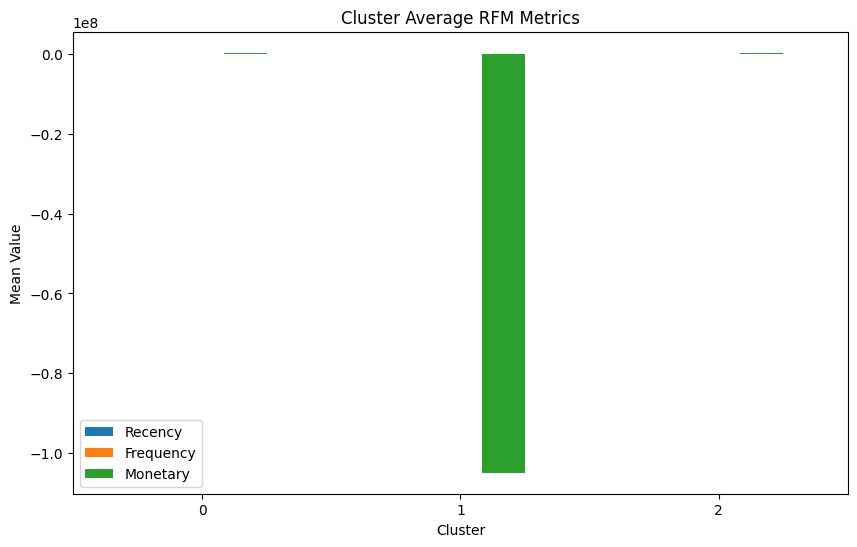

In [15]:
cluster_summary = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()
cluster_summary.plot(kind='bar', figsize=(10,6))
plt.title('Cluster Average RFM Metrics')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.show()


## Step 5 — High-Risk Customer Count
Check how many customers fall into the high-risk cluster.


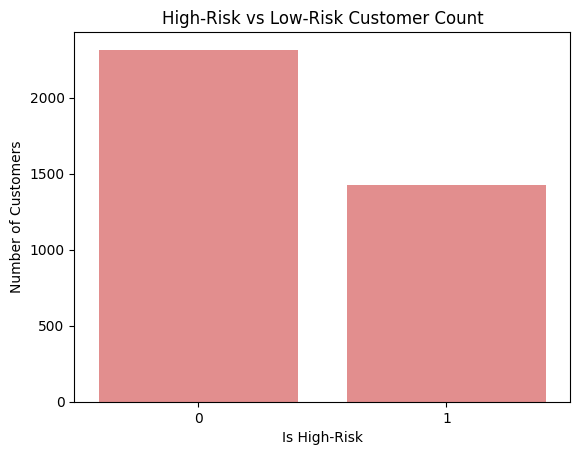

In [17]:
sns.countplot(x='is_high_risk', data=rfm, color='lightcoral')
plt.title('High-Risk vs Low-Risk Customer Count')
plt.xlabel('Is High-Risk')
plt.ylabel('Number of Customers')
plt.show()
